# Description: Predicting Ethereum Price with Python and Machine Learning using Tensorflow and Keras and LSTM

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the data
data = pd.read_csv('ethereum_2015-08-07_2024-06-02.csv')

# Sort data by the 'Start' date
data = data.sort_values('Start')

# Select relevant features
features = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Convert the scaled features into a DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=features.columns)

# Display the first few rows of the scaled data
print(scaled_data.head())






       Open      High       Low     Close    Volume
0  0.000485  0.000476  0.000062  0.000057  0.000002
1  0.000066  0.000082  0.000044  0.000060  0.000004
2  0.000055  0.000051  0.000046  0.000056  0.000003
3  0.000057  0.000133  0.000051  0.000128  0.000004
4  0.000131  0.000166  0.000098  0.000166  0.000014


## Create Sequences for LSTM

In [9]:
import numpy as np

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length]
        target = data[i+sequence_length, 3]  # Assuming 'Close' is the target
        sequences.append((sequence, target))
    return sequences

sequence_length = 60  # Example sequence length
sequences = create_sequences(scaled_features, sequence_length)

# Split into training and testing sets
train_size = int(len(sequences) * 0.8)
train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]

# Prepare the data for the LSTM model
X_train = np.array([seq[0] for seq in train_sequences])
y_train = np.array([seq[1] for seq in train_sequences])
X_test = np.array([seq[0] for seq in test_sequences])
y_test = np.array([seq[1] for seq in test_sequences])


## Build and Train the LSTM Model


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


c:\Users\Student\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.9428e-04 - val_loss: 0.0047
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 2.5773e-04 - val_loss: 0.0041
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 2.4561e-04 - val_loss: 0.0036
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 2.4408e-04 - val_loss: 0.0031
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.1694e-04 - val_loss: 0.0058
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 2.3315e-04 - val_loss: 0.0042
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 2.5523e-04 - val_loss: 0.0027
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 2.1557e-04 - val_loss: 0.0026
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 2.2588e-04 - val_loss: 0.0026
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 1.7677e-04 - val_loss: 0.0034
Epoch 12/20
64/64 ━━━━━

In [11]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')



20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.9616e-04
Test Loss: 0.0004538935609161854
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


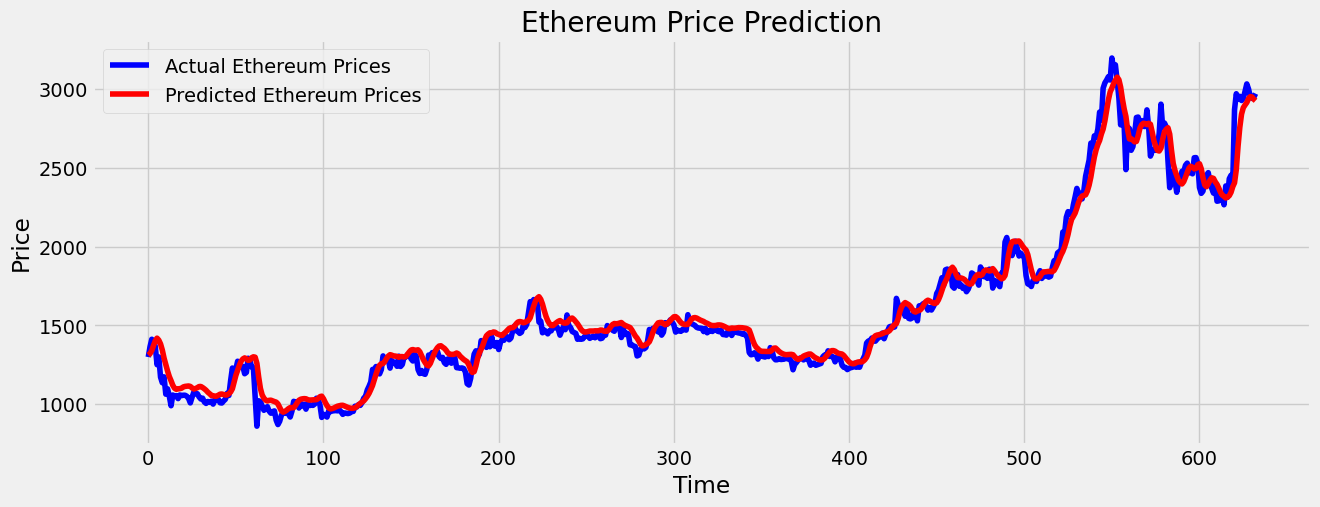

In [14]:
# Make predictions
predictions = model.predict(X_test)

# Reshape the predictions to match the scaler's expected input shape
predictions = predictions.reshape(-1, 1)

# Prepare a dummy array with the same shape as the scaled data (Open, High, Low, Close, Volume)
dummy_array = np.zeros((predictions.shape[0], scaled_features.shape[1]))

# Replace the 'Close' column in the dummy array with the predictions
dummy_array[:, 3] = predictions[:, 0]

# Perform inverse transformation
inverse_transformed_predictions = scaler.inverse_transform(dummy_array)

# Extract the predicted Close prices
predicted_prices = inverse_transformed_predictions[:, 3]

# Invert scaling for actual Close prices
actual_prices = y_test.reshape(-1, 1)
dummy_array = np.zeros((actual_prices.shape[0], scaled_features.shape[1]))
dummy_array[:, 3] = actual_prices[:, 0]
inverse_transformed_actual = scaler.inverse_transform(dummy_array)
actual_prices = inverse_transformed_actual[:, 3]

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(actual_prices, color='blue', label='Actual Ethereum Prices')
plt.plot(predicted_prices, color='red', label='Predicted Ethereum Prices')
plt.title('Ethereum Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


# Save the Model

In [21]:
model.save('ethereum_price_prediction_lstm.keras')


## Load model

In [20]:
from tensorflow.keras.models import load_model

model = load_model('ethereum_price_prediction_lstm.h5')


10. Hyperparameter Tuning
Experiment with different hyperparameters (e.g., number of LSTM units, dropout rates, batch size, epochs) to improve the model's performance. You can use techniques like grid search or random search for hyperparameter tuning.

11. Model Optimization
Consider implementing more advanced techniques to optimize your model, such as:

# Corrected Code for Model Optimization and Hyperparameter Tuning


# Early Stopping: To stop training when the model stops improving.
# Learning Rate Scheduler: To adjust the learning rate during training.

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def create_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    # Create a new optimizer instance
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model with the new optimizer
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model



# Train the model with early stopping:

In [24]:
# Create the model
model = create_model()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100


c:\Users\Student\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0026 - val_loss: 0.0143
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 3.5172e-04 - val_loss: 0.0045
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 3.7889e-04 - val_loss: 0.0044
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 2.4262e-04 - val_loss: 0.0040
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 2.7767e-04 - val_loss: 0.0061
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 2.6346e-04 - val_loss: 0.0042
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1.9476e-04 - val_loss: 0.0029
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 2.9268e-04 - val_loss: 0.0053
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 2.3079e-04 - val_loss: 0.0027
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 2.2004e-04 - val_loss: 0.0035
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 2.2610e-04 - val_loss: 0.0029
Epoch 12/100
64/64 ━━━━

#Hyperparameter Tuning

In [ ]:
import kerastuner as kt

def model_builder(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=hp_units, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    # Choose an optimal learning rate between 0.01 and 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error')
    
    return model

tuner = kt.Hyperband(model_builder,
                    objective='val_loss',
                    max_epochs=20,
                    factor=3,
                    directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)
